In [1]:
%matplotlib inline

import theano
import cPickle
import numpy as np
from theano import tensor, function
from pylab import imshow
from pylab import rcParams

from agnez.weight import grid2d
from fuel.datasets import MNIST
from fuel.streams import DataStream
from fuel.transformers import Mapping
from fuel.schemes import SequentialScheme
from blocks.bricks.cost import MisclassificationRate

from blocks_contrib.probability import Pserver
from blocks_contrib.datasets import rotated_dataset, Meanizer

import seaborn as sns
sns.set_style('dark')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
    leng = 1000
    batch_size=100
    mnist_test = MNIST("test", stop=leng)
    teststream = Mapping(DataStream(mnist_test,
                             iteration_scheme=SequentialScheme(
                                 leng,
                                 batch_size)), rotated_dataset(20))
    # meanizer = Meanizer(trainstream)
    # trainstream = Mapping(trainstream, meanizer.meanless)
    # teststream = Mapping(teststream, meanizer.meanless)

#### Load models and data

In [69]:
def autocorrentropy(X, sigma=1):
    b, t, d = X.shape
    V = np.zeros((b, t))
    nor = np.sqrt(2*np.pi)*sigma
    dem = 2*sigma**2
    for i in range(b):
        for j in range(t):
            V[i, j] = np.exp((-(X[i, :(t-j)]-X[i, j:])**2).sum() / dem / (t-j)) / nor
    return V

def autocorrentropy2(X, sigma=1):
    b, t, d = X.shape
    V = np.zeros((b, t, d))
    nor = np.sqrt(2*np.pi)*sigma
    dem = 2*sigma**2
    for i in range(b):
        for j in range(t):
            V[i, j, :] = np.exp((-(X[i, :(t-j), :]-X[i, j:, :])**2).sum(axis=0) / dem/(t-j)) / nor
            #V[i, j, :] = ((X[i, :(t-j), :]-X[i, j:, :])**2).sum(axis=0)
    return V

In [70]:
X = np.random.normal(0, 1, (100, 20, 784))
V = autocorrentropy2(X)

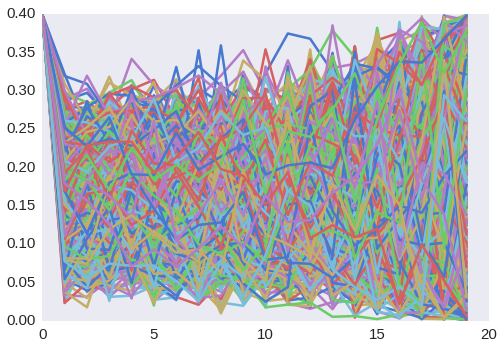

In [71]:
_ = plt.plot(V[1])

In [72]:
z = np.zeros((leng, 20))
x = np.zeros((leng, 20*784))
y = np.zeros((leng, 20*784))

labels = np.zeros(leng)

sigma=1
for i,b in enumerate(teststream.get_epoch_iterator()):
    first = i*100
    last = (i+1)*100
    data = b[0].transpose(1, 0, 2)
    z[first:last] = autocorrentropy(data, sigma=sigma)
    x[first:last] = data.reshape((100, -1))
    y[first:last] = autocorrentropy2(data, sigma=sigma).reshape((100, -1))
    labels[first:last] = b[1][:,0]
    
labels = labels.astype('int')

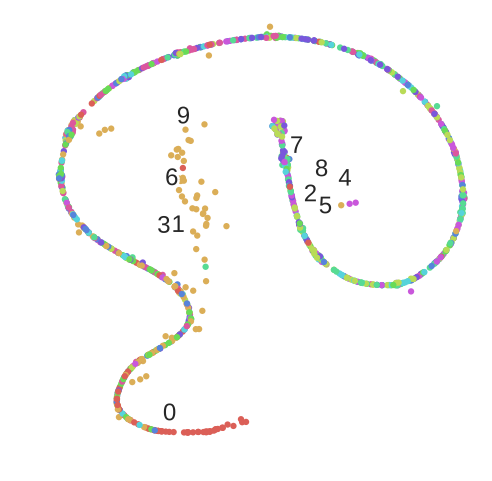

In [73]:
from sklearn.manifold.t_sne import TSNE

from agnez import embedding2d, embedding2dplot
tsne = TSNE(perplexity=40)
ebd, tsne = embedding2d(z, method=tsne)
_ = embedding2dplot(ebd, labels)

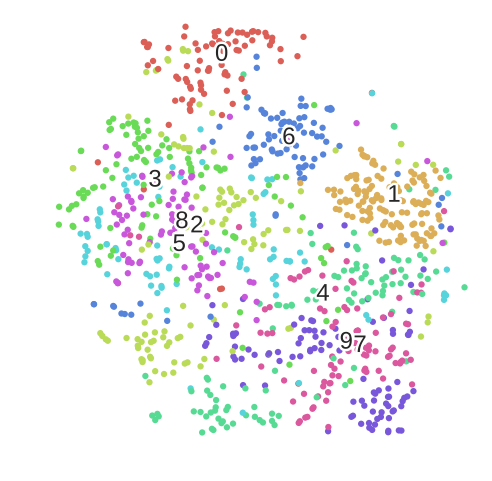

In [74]:
tsne = TSNE(perplexity=40)
ebd, tsne = embedding2d(y, method=tsne)
_ = embedding2dplot(ebd, labels)

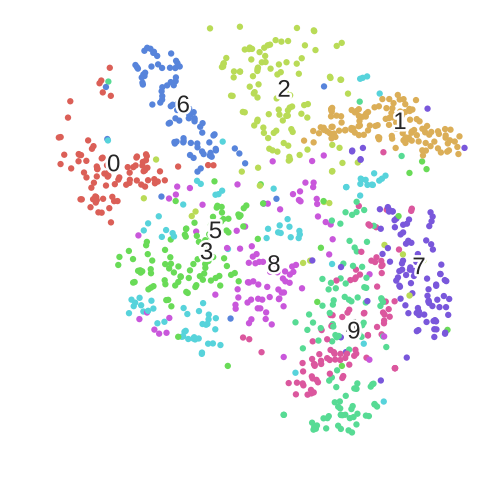

In [51]:
tsne = TSNE(perplexity=40)
ebd, tsne = embedding2d(x, method=tsne)
_ = embedding2dplot(ebd, labels)